In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *
from wrfProcessing import *

import warnings
from tabulate import tabulate

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    
    cont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.midlatmountain.100km.800d"              ,"Midlat mountain, control"         ,sel_midlatmountain,open_ds=0)
    warm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.midlatmountain.100km.SST2K_2XCO2.800d"  ,"Midlat mountain, SST +2K, 2*CO2"  ,sel_midlatmountain,open_ds=0)

    

loading time : 0.0 s
Daily precips already computed
precips time : 0.2 s
loading time : 0.0 s
Daily precips already computed
precips time : 0.2 s


In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    
    Acont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.aquaplanet.100km.1000d"            ,"Aquaplanet, control"       ,sel_midlatmountain,open_ds=0)
    Awarm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.aquaplanet.100km.SST2K_2XCO2.1000d","Aquaplanet, SST +2K, 2*CO2",sel_midlatmountain,open_ds=0)
    

loading time : 0.0 s
Daily precips already computed
precips time : 0.2 s
loading time : 0.0 s
Daily precips already computed
precips time : 0.2 s


In [21]:
def set_pctile(pctile):
    for ds in [cont,warm,Acont,Awarm]:
        ds.set_extreme_precip(pctile/100)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore",RuntimeWarning)
            warnings.simplefilter("ignore",FutureWarning)
            ds.set_extreme_vars(pctile/100)
            ds.compute_ogscaling()

In [22]:
pctile=99
set_pctile(pctile)

# Orography

Text(0.5, 1.0, 'Orography')

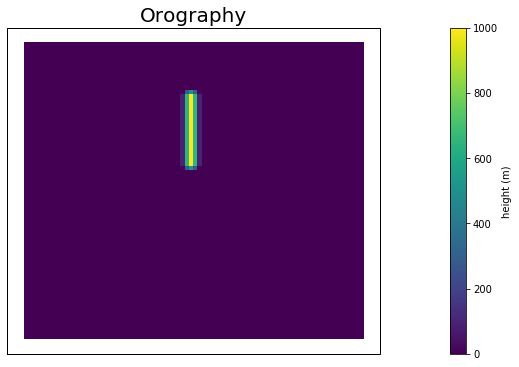

In [5]:
SCRATCH = "/global/cscratch1/sd/qnicolas/"
orog = xr.open_dataset(SCRATCH+"wrfdata/saved/wrf.midlatmountain.100km.800d/wrf.midlatmountain.100km.800d.0001-01-01.nc_orig",use_cftime=True).HGT

fig, ax = plt.subplots(1,1,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})
orog.isel(Time=0).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"height (m)"})#,"ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(0,40.,100))
ax.set_title("Orography",fontsize=20)

# Zonal-mean precip

Text(0.5, 1.0, 'Large Scale precip')

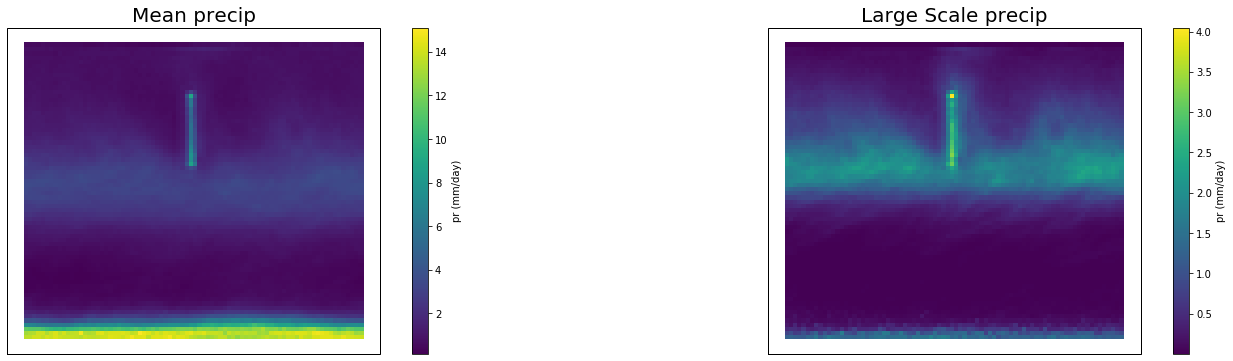

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,6),subplot_kw={'projection': ccrs.PlateCarree()})

cont.precip_daily.mean("time").plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(-0.02,0.021,0.004)},levels=np.linspace(0,40.,100))
cont.precip_g_daily.mean("time").plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)"})#,"ticks":np.arange(0.,41.,10.)},levels=np.linspace(0,40.,100))
ax1.set_title("Mean precip" ,fontsize=20)
ax2.set_title("Large Scale precip",fontsize=20)


0.39179491996765137
Mean precip increase 6.90%/K


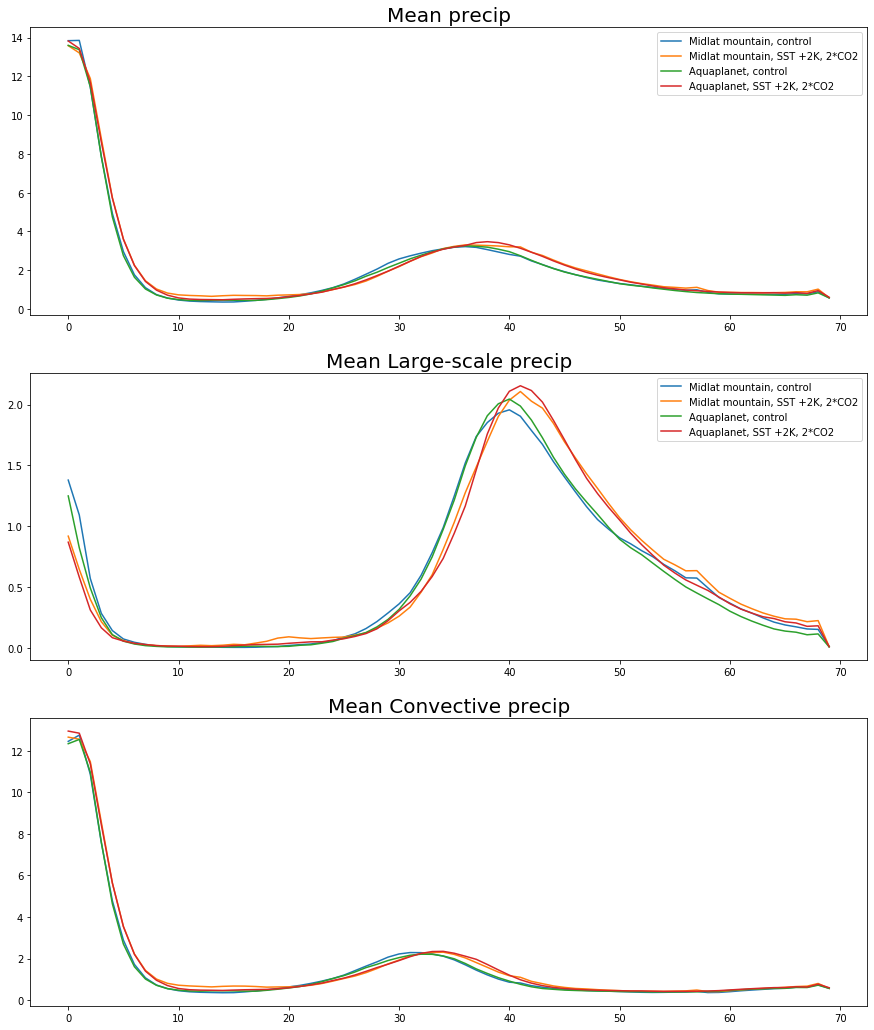

In [7]:
t=time.time()
fig, ax = plt.subplots(3,1,figsize=(15,3*6))
for ds in [cont,warm,Acont,Awarm]:
    ax[0].plot(ds.precip_daily.south_north,ds.precip_daily.mean(["time","west_east"]),label=ds.lbl)
    ax[1].plot(ds.precip_daily.south_north,ds.precip_g_daily.mean(["time","west_east"]),label=ds.lbl)
    ax[2].plot(ds.precip_daily.south_north,ds.precip_c_daily.mean(["time","west_east"]),label=ds.lbl)
print(time.time()-t)
ax[0].set_title("Mean precip",fontsize=20)
ax[1].set_title("Mean Large-scale precip",fontsize=20)
ax[2].set_title("Mean Convective precip",fontsize=20)

for a in ax[:-1] :a.legend()
print("Mean precip increase %.2f%%/K"%(100*(warm.precip_daily.mean(["time","west_east","south_north"])-cont.precip_daily.mean(["time","west_east","south_north"]))/cont.precip_daily.mean(["time","west_east","south_north"])))

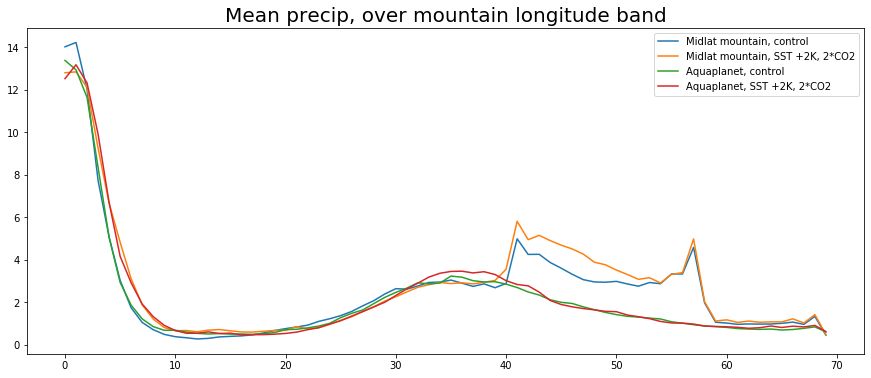

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
for ds in [cont,warm,Acont,Awarm]:
    ax.plot(ds.precip_daily.south_north,ds.precip_daily.isel(west_east=range(37,40)).mean(["time","west_east"]),label=ds.lbl)
ax.set_title("Mean precip, over mountain longitude band",fontsize=20)
ax.legend()


# Precipitation extremes

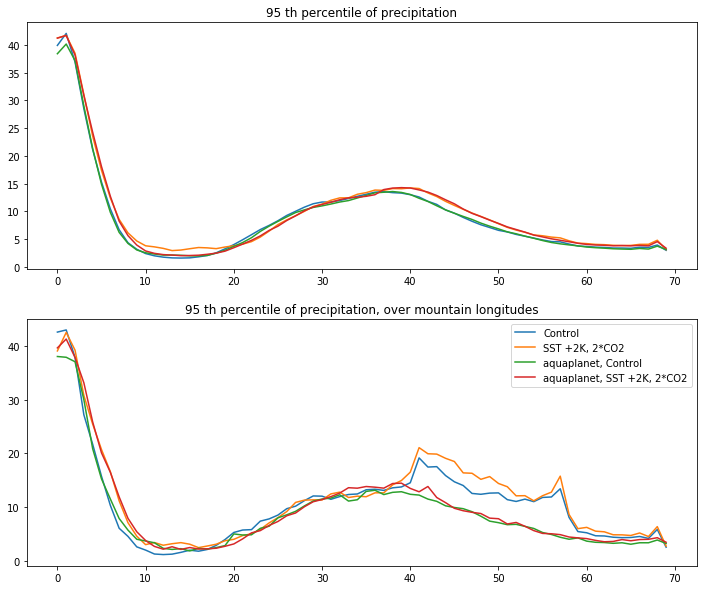

In [28]:
fig, ax = plt.subplots(2,1,figsize=(12,10))

for ds in [cont,warm,Acont,Awarm]:
    ax[0].plot(ds.vars.south_north,ds.ex_pr_zonmean,label=ds.lbl)
    ax[0].set_title("%i th percentile of precipitation"%pctile)
    ax[1].plot(ds.vars.south_north,ds.ex_pr.sel(west_east=slice(37,40)).mean("west_east"),label=ds.lbl)
    ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

## Vertical motion profiles over tropics/mountains on precip extremes days

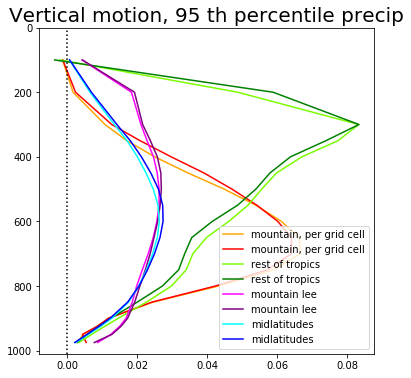

In [89]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

def plot_w(ax,cont,warm,pctile):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
        ax.plot(sel_mountain(cont.ex_w).mean(["south_north","west_east"]),cont.ex_w.level,label="mountain, per grid cell",color="orange")
        ax.plot(sel_mountain(warm.ex_w).mean(["south_north","west_east"]),warm.ex_w.level,label="mountain, per grid cell",color="red")
         
        ax.plot(cont.ex_w.isel(south_north=range(5)).sel(west_east=((cont.ex_w.west_east<20)|(cont.ex_w.west_east>60))).mean(["south_north","west_east"]),cont.ex_w.level,label="rest of tropics",color="lawngreen")
        ax.plot(warm.ex_w.isel(south_north=range(5)).sel(west_east=((warm.ex_w.west_east<20)|(warm.ex_w.west_east>60))).mean(["south_north","west_east"]),warm.ex_w.level,label="rest of tropics",color="green")

        ax.plot(sel_lee(cont.ex_w).mean(["south_north","west_east"]),cont.ex_w.level,label="mountain lee",color="magenta")
        ax.plot(sel_lee(warm.ex_w).mean(["south_north","west_east"]),warm.ex_w.level,label="mountain lee",color="purple")
    
        ax.plot(mean_midlatitudes(cont.ex_w),cont.ex_w.level,label="midlatitudes",color="cyan")
        ax.plot(mean_midlatitudes(warm.ex_w),warm.ex_w.level,label="midlatitudes",color="blue")
        
    ax.axvline(0,linestyle=':',color='k')
    
    ax.set_title("Vertical motion, %i th percentile precip"%pctile,fontsize=20)
    ax.legend(loc='lower right')
    ax.set_ylim(1010,0)
    
plot_w(ax,cont,warm,pctile)

## Extreme precipitation sensitivity

Text(0.5, 0.98, 'Sensitivity of the 95 th pctile of precip, %/(K of global mean temperature)')

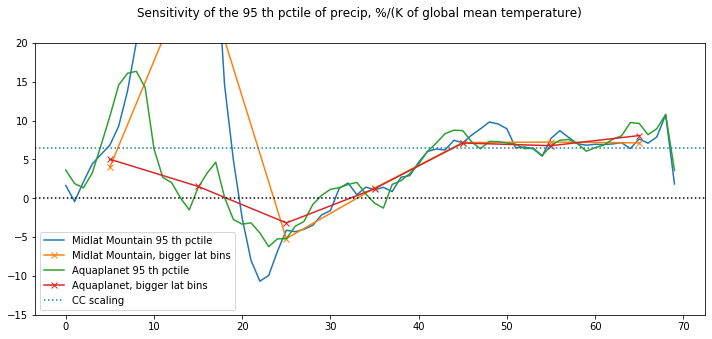

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

def plot_sens(ax,cont,warm,lbl):
    ax.plot(cont.vars.south_north,100*(warm.ex_pr_zonmean-cont.ex_pr_zonmean)/cont.ex_pr_zonmean/meanTinc, label = lbl+" %i th pctile"%pctile)
    #ax.plot(cont2.vars.south_north,100*(warm2.ex_pr_zonmean-cont2.ex_pr_zonmean)/cont2.ex_pr_zonmean/meanTinc, label = "%i th pctile"%pctile2)
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=FutureWarning)       
        resample_factor=10
        resampled_pr95_warm = warm.ex_pr.groupby(((warm.vars.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
        resampled_pr95_cont = cont.ex_pr.groupby(((cont.vars.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    ax.plot(resampled_pr95_warm.south_north,100*(resampled_pr95_warm-resampled_pr95_cont)/resampled_pr95_cont/2,'-x',label=lbl+", bigger lat bins")

plot_sens(ax,cont,warm,'Midlat Mountain')
plot_sens(ax,Acont,Awarm,'Aquaplanet')

ax.axhline(6.5,linestyle=":",label="CC scaling")
ax.axhline(0.,linestyle=":",color="k")

ax.set_ylim(-15,20)

plt.legend()
fig.suptitle("Sensitivity of the %i th pctile of precip, %%/(K of global mean temperature)"%pctile)

0.029996871948242188
0.027192354202270508
0.043488264083862305
0.03081798553466797


Text(0.5, 0.98, 'Sensitivity of the 99 th pctile of precip, %/(K of global mean temperature)')

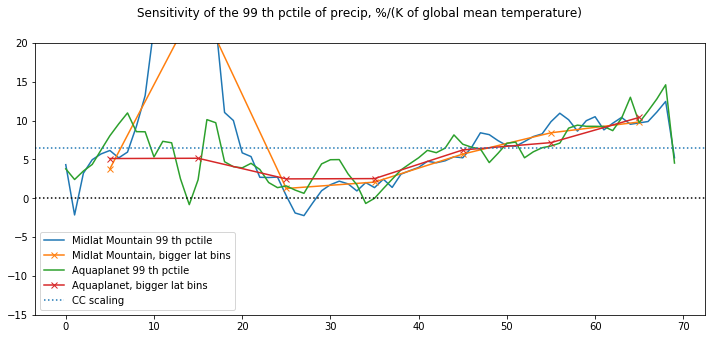

In [12]:
pctile=99;meanTinc=2
for ds in [cont,warm,Acont,Awarm]:
    t = time.time()
    ds.set_extreme_precip(pctile/100)
    #ds.set_extreme_precip_mountain(pctile/100)
    print(time.time()-t)

fig, ax = plt.subplots(1,1,figsize=(12,5))

def plot_sens(ax,cont,warm,lbl):
    ax.plot(cont.precip_daily.south_north,100*(warm.ex_pr_zonmean-cont.ex_pr_zonmean)/cont.ex_pr_zonmean/meanTinc, label = lbl+" %i th pctile"%pctile)
    #ax.plot(cont2.precip_daily.south_north,100*(warm2.ex_pr_zonmean-cont2.ex_pr_zonmean)/cont2.ex_pr_zonmean/meanTinc, label = "%i th pctile"%pctile2)
    
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=FutureWarning)       
        resample_factor=10
        resampled_pr95_warm = warm.ex_pr.groupby(((warm.precip_daily.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
        resampled_pr95_cont = cont.ex_pr.groupby(((cont.precip_daily.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    ax.plot(resampled_pr95_warm.south_north,100*(resampled_pr95_warm-resampled_pr95_cont)/resampled_pr95_cont/2,'-x',label=lbl+", bigger lat bins")

plot_sens(ax,cont,warm,'Midlat Mountain')
plot_sens(ax,Acont,Awarm,'Aquaplanet')

ax.axhline(6.5,linestyle=":",label="CC scaling")
ax.axhline(0.,linestyle=":",color="k")

ax.set_ylim(-15,20)

plt.legend()
fig.suptitle("Sensitivity of the %i th pctile of precip, %%/(K of global mean temperature)"%pctile)

## Extreme events over the mountain

In [ ]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot([0,20],[0,20],':k')#,color="lightgrey")
for ds in [cont,warm] :
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_all,label=ds.lbl)
    #ax.scatter(p95,precip_g_mountain_p95 ,label="large-scale precip")
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_og_all,label=ds.lbl+", OG w/ true omega")
    #ax.scatter(p95,pr_og_sin_p95_mountain,label="OG w/ u.grad(h), 1st baroclinic mode profile")
    #ax.scatter(p95,pr_roe_mountain_p95   ,label="Roe")
    ax.legend()

In [ ]:
_,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot([0,20],[0,20],':k')#,color="lightgrey")
for ds in [cont,warm] :
    pr_eff = np.mean(np.array(ds.ex_pr_mountain_og_all))/np.mean(np.array(ds.ex_pr_mountain_all))
    print('precip efficiency, %s : %.2f'%(ds.lbl,1/pr_eff))
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_all,label=ds.lbl)
    #ax.scatter(p95,precip_g_mountain_p95 ,label="large-scale precip")
    ax.scatter(ds.ex_pr_mountain_all,ds.ex_pr_mountain_og_all/pr_eff,label=ds.lbl+", OG w/ true omega")
    #ax.scatter(p95,pr_og_sin_p95_mountain,label="OG w/ u.grad(h), 1st baroclinic mode profile")
    #ax.scatter(p95,pr_roe_mountain_p95   ,label="Roe")
    ax.legend()

## Sensitivity breakdown (Fildier et al 2017)

In [19]:
tropics_limit=5

def sel_lee(ds):
    return ds.sel(west_east=slice(41,43),south_north=slice(40,59))

def mean_lee(x):
    return sel_lee(x).mean(['west_east','south_north'])
def mean_mountain(x):
    return sel_midlatmountain(x).mean(['west_east','south_north'])
def mean_rest_midlatitudes(x):
    return x.isel(south_north=range(40,60)).sel(west_east=((x.west_east<20)|(x.west_east>60))).mean(['west_east','south_north'])

def mean_tropics(x):
    return x.isel(south_north=range(tropics_limit)).mean(['west_east','south_north'])
def mean_midlatitudes(x):
    return x.isel(south_north=range(40,60)).mean(['west_east','south_north'])



In [20]:
def bsensitivity_breakdown(cont,warm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1):
    meanTinc=2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
                      
        prsensm  = bPR(cont,warm,meanTinc,mean_mountain    )
        prsensl  = bPR(cont,warm,meanTinc,mean_lee         )
        prsenst  = bPR(cont,warm,meanTinc,mean_tropics     )
        prsenss  = bPR(cont,warm,meanTinc,mean_subtropics  )
        prsense  = bPR(cont,warm,meanTinc,mean_midlatitudes)
        
        em  = bE(cont,warm,meanTinc,mean_mountain    )
        el  = bE(cont,warm,meanTinc,mean_lee         )
        et  = bE(cont,warm,meanTinc,mean_tropics     )
        es  = bE(cont,warm,meanTinc,mean_subtropics  )
        ee  = bE(cont,warm,meanTinc,mean_midlatitudes)
        
        d1m  = bD1(cont,warm,meanTinc,mean_mountain    )
        d1l  = bD1(cont,warm,meanTinc,mean_lee         )
        d1t  = bD1(cont,warm,meanTinc,mean_tropics     )
        d1s  = bD1(cont,warm,meanTinc,mean_subtropics  )
        d1e  = bD1(cont,warm,meanTinc,mean_midlatitudes)
        
        d2m  = bD2(cont,warm,meanTinc,mean_mountain    )
        d2l  = bD2(cont,warm,meanTinc,mean_lee         )
        d2t  = bD2(cont,warm,meanTinc,mean_tropics     )
        d2s  = bD2(cont,warm,meanTinc,mean_subtropics  )
        d2e  = bD2(cont,warm,meanTinc,mean_midlatitudes)
        
        thm  = bT(cont,warm,meanTinc,mean_mountain    )
        thl  = bT(cont,warm,meanTinc,mean_lee         )
        tht  = bT(cont,warm,meanTinc,mean_tropics     )
        ths  = bT(cont,warm,meanTinc,mean_subtropics  )
        the  = bT(cont,warm,meanTinc,mean_midlatitudes)
        
    print(' '*30+'\033[1m'+ "Extreme precip sensitivity breakdown, %i th percentile"%pctile + '\033[0m')
    
    tab=[['Tropics - 0°-%i°'%tropics_limit ,"%.2f"%(100*prsenst),"%.2f"%(100*et),"%.2f"%(100*d1t),"%.2f"%(100*d2t),"%.2f"%(100*tht),"%.2f"%(100*(prsenst-et-d1t-d2t-tht))],
         ['Midlatitudes - 40°-60°',         "%.2f"%(100*prsense),"%.2f"%(100*ee),"%.2f"%(100*d1e),"%.2f"%(100*d2e),"%.2f"%(100*the),"%.2f"%(100*(prsense-ee-d1e-d2e-the))],
        ]
    if mountain :
        tab += [['Mountain - Windward slope',"%.2f"%(100*prsensm),"%.2f"%(100*em),"%.2f"%(100*d1m),"%.2f"%(100*d2m),"%.2f"%(100*thm),"%.2f"%(100*(prsensm-em-d1m-d2m-thm))],
                ['Mountain - Lee',           "%.2f"%(100*prsensl),"%.2f"%(100*el),"%.2f"%(100*d1l),"%.2f"%(100*d2l),"%.2f"%(100*thl),"%.2f"%(100*(prsensl-el-d1l-d2l-thl))],
               ]
    
    print(tabulate(tab, headers=['Region', 'Precip (%)', 'Efficiency (%)', 'D1 (%)', 'D2 (%)', 'T (%)', 'N (%)']))


In [25]:
print("Midlat Mountain")
t=time.time()
bsensitivity_breakdown(cont,warm,pctile,mean_tropics,mean_rest_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Midlat Mountain
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                       Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
-------------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                    2.7               1.1      -0.75     -1.26     5.89    -2.28
Midlatitudes - 40°-60°             6.03              0.39      1.5      -0.53     5.67    -0.99
Mountain - Windward slope          6.27              0.39     -0        -1.03     8.07    -1.16
Mountain - Lee                    10.62              0.43      4.55     -0.86     7.4     -0.9
117.14805912971497
Aquaplanet
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°        

In [26]:
pctile=95
set_pctile(pctile)
print("Midlat Mountain")
t=time.time()
bsensitivity_breakdown(cont,warm,pctile,mean_tropics,mean_rest_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Midlat Mountain
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                       Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
-------------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                    2.23              0.77     -1.84     -1.19     6.32    -1.83
Midlatitudes - 40°-60°             7.27              0.75      1.61     -0.65     5.99    -0.43
Mountain - Windward slope          7.41              0.7       1.08     -0.89     7.64    -1.11
Mountain - Lee                    10.25              2.08      1.43     -0.05     6.37     0.42
123.21375155448914
Aquaplanet
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°       